## Wine Embeddings and a Wine Recommender

### 1. Introduction

One of the cornerstones of every chapter of the Robosomm series has been to extract descriptors from professional wine reviews, and to convert these into quantitative features. In doing so, we want to put ourselves in the shoes of a blind taster and extract only those descriptors that could be derived without knowing what the wine actually is. 

In this notebook, we will combine a couple of best-practice approaches highlighted in the existing literature on this subject and create an embedding for each wine review. We will use this to build a simple wine recommender.

In [1]:
import os
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from collections import Counter, OrderedDict

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

### 1. The Raw Dataset

The raw dataset consists of roughly 180,000 wine reviews from www.winemag.com. These reviews span about 20 years and a few dozen grape varieties. These reviews have been scraped one variety at a time, so the first step is to consolidate the various CSV files with the results of the scraping exercise.

In [2]:
print(os.listdir(r'/Users/saruul/Desktop/c4h/Wine/wine_demo/data/'))

['all_scraped_wine_info_Gamay.csv', 'misc', 'all_scraped_wine_info_sauvignon_blanc.csv', 'all_scraped_wine_info_Viognier.csv', 'all_scraped_wine_info_Syrah.csv', 'all_scraped_wine_info_Chardonnay.csv', '.DS_Store', 'all_scraped_wine_info_SparklingBlend.csv', 'bin', 'all_scraped_wine_info_CabernetSauvignon.csv', 'all_scraped_wine_info_Bordeaux-styleRedBlend.csv', 'all_scraped_wine_info_WhiteBlend.csv', 'all_scraped_wine_info_PinotNoir.csv', 'all_scraped_wine_info_Merlot.csv', 'all_scraped_wine_info_Malbec.csv', 'all_scraped_wine_info_Rhone-styleRedBlend.csv', 'all_scraped_wine_info_Nebbiolo.csv', 'all_scraped_wine_info_RedBlend.csv', 'all_scraped_wine_info_PinotGris.csv', 'all_scraped_wine_info_Sangiovese.csv', 'all_scraped_wine_info_PortugueseRed.csv', 'descriptor', '.ipynb_checkpoints', 'all_scraped_wine_info_PortugueseWhite.csv', 'all_scraped_wine_info_CabernetFranc.csv', 'all_scraped_wine_info_GrunerVeltliner.csv', 'all_scraped_wine_info_zinfandel.csv', 'all_scraped_wine_info_riesli

In [3]:
base_location = r'/Users/saruul/Desktop/c4h/Wine/wine_demo/data/'

i = 0
for file in os.listdir(base_location):
    if file.endswith ('.csv'):
        file_location = base_location + '/' + str(file)
        print(file)
        if i==0:
            wine_dataframe = pd.read_csv(file_location, encoding='latin-1')
            i+=1
        else:
            df_to_append = pd.read_csv(file_location, encoding='latin-1', low_memory=False)
            wine_dataframe = pd.concat([wine_dataframe, df_to_append], axis=0)

wine_dataframe.drop_duplicates(subset=['Name'], inplace=True)
print(wine_dataframe.shape)

all_scraped_wine_info_Gamay.csv
all_scraped_wine_info_sauvignon_blanc.csv
all_scraped_wine_info_Viognier.csv
all_scraped_wine_info_Syrah.csv
all_scraped_wine_info_Chardonnay.csv
all_scraped_wine_info_SparklingBlend.csv
all_scraped_wine_info_CabernetSauvignon.csv
all_scraped_wine_info_Bordeaux-styleRedBlend.csv
all_scraped_wine_info_WhiteBlend.csv
all_scraped_wine_info_PinotNoir.csv
all_scraped_wine_info_Merlot.csv
all_scraped_wine_info_Malbec.csv
all_scraped_wine_info_Rhone-styleRedBlend.csv
all_scraped_wine_info_Nebbiolo.csv
all_scraped_wine_info_RedBlend.csv
all_scraped_wine_info_PinotGris.csv
all_scraped_wine_info_Sangiovese.csv
all_scraped_wine_info_PortugueseRed.csv
all_scraped_wine_info_PortugueseWhite.csv
all_scraped_wine_info_CabernetFranc.csv
all_scraped_wine_info_GrunerVeltliner.csv
all_scraped_wine_info_zinfandel.csv
all_scraped_wine_info_riesling.csv
all_scraped_wine_info_Tempranillo.csv
all_scraped_wine_info_Rose.csv
(23090, 23)


### 2. Extracting Wine Descrpitors

To begin this analysis, we need to extract descriptors from our reviews and create a categorization of these descriptors at various levels of specificity. Here, I drew inspiration from some of the great work by Bernard Chen and others on the Computational Wine Wheel (https://www.springerprofessional.de/en/the-computational-wine-wheel-2-0-and-the-trimax-triclustering-in/10290536). 

Descriptors are extracted in a few steps, outlined in the cells below: first, all the wine reviews are conslidated into one large corpus. They are then tokenized into sentences.

In [4]:
reviews_list = list(wine_dataframe['Description'])
reviews_list = [str(r) for r in reviews_list]
full_corpus = ' '.join(reviews_list)
sentences_tokenized = sent_tokenize(full_corpus)

print(sentences_tokenized[:5])

['Quite hazy in the glass, this bottling is sharp on the nose with plum-skin and snappy currant aromas, as loamy soil and cracked pepper scents add nuance.', 'While the mouthfeel is full and broad, the This rather new grape for the Santa Barbara regions comes from a brand-new planting near Los Alamos.', 'Muddled berry and purple-flower aromas meet with loamy soil scents on the nose.', 'The palate is juicy A ripe wine with soft fruit and equally light tannins, this is full of red fruits and balanced acidity.', 'It is very ready to drink.']


Next, the text in each sentence is normalized (tokenize, remove punctuation and remove stopwords).

In [5]:
stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

# sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in sentences_tokenized:
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

Not all of the terms we are interested in are single words. Some of the terms are phrases, consisting of two (or more!) words. An example of this might be 'high tannin'. We can use gensim's Phrases feature to extract all the most relevant bi- and tri-grams from our corpus.

In [6]:
phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in normalized_sentences:
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

Next, we will extract the most common words and rank these by how frequently they appear.

In [7]:
word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
# top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')

Now for the most important part: leveraging existing wine theory, the work of others like Bernard Chen, wine descriptor mappings and the UC Davis wine wheel, the top 5000 most frequent wine terms were reviewed to (i) determine whether they are a descriptor that can be derived by blind tasting, and (ii) whether they are informative (judgments like 'tasty' and 'great' are not considered to be informative). The roughly 1000 descriptors that remain were then mapped onto a normalized descriptor, a category and a class:

In [12]:
descriptor_mapping = pd.read_csv('../data/descriptor/descriptor_mapping.csv').set_index('raw descriptor')
descriptor_mapping.head(10)

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
acacia,acacia,flowery,flower
acacia_flower,acacia,flowery,flower
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid
airi,airy,light_bodied,body
allspic,allspice,baking_spices,spice
almond,almond,nutty,nutty
almond_past,almond,nutty,nutty


Next, any terms in the corpus that appear in the overview above are mapped onto the 'level_3' (the most specific) layer in the table.

In [13]:
def return_mapped_descriptor(word):
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return word

normalized_sentences = []
for sent in phrased_sentences:
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        normalized_sentence += [str(normalized_word)]
    normalized_sentences += [normalized_sentence]

### 3. From Wine Descriptors to Word Embeddings

We can now proceed to train a Word2Vec model on our normalized and descriptor-mapped corpus. This will allow us to get a word embedding for every term in the corpus. In order to reduce the overall size of the corpus, we will exclude any terms that appear fewer than 5 times across all the wine reviews.

In [14]:
wine_word2vec_model = Word2Vec(normalized_sentences, vector_size=300, min_count=5, epochs=15)
print(wine_word2vec_model)

wine_word2vec_model.save('../data/bin/wine_word2vec_model.bin')

Word2Vec<vocab=4737, vector_size=300, alpha=0.025>


Let's take a closer look at our trained Word2Vec model - what wine descriptors are most similar to the word 'peach'?

In [15]:
wine_word2vec_model.wv.most_similar(positive='peach', topn=10)

[('honeydew', 0.7931021451950073),
 ('grapefruit', 0.7865452170372009),
 ('guava', 0.7694220542907715),
 ('tangerine', 0.7671331167221069),
 ('stone_fruit', 0.7664572596549988),
 ('nectarine', 0.7661294937133789),
 ('cataloupe', 0.7612780928611755),
 ('green_melon', 0.7593855857849121),
 ('papaya', 0.7563067674636841),
 ('quince', 0.7488659024238586)]

In [16]:
# wine_word2vec_model.wv.most_similar(positive='aesthetic', topn=10) - no aesthetic yet

Excellent! These words are all relatively similar to the word peach. It seems that our Word2Vec model is working well. 

### 4. From Word Embeddings to Wine Review Embeddings

Now, we need to find a way to create a single embedding for each wine review, combining all the relevant word embeddings contained within it.

First, we will extract a set of mapped & normalized descriptors from each wine review. Unlike when we were training our Word2Vec model (when in-between words with semantic meaning could help create more accurate embeddings), we will remove any descriptors that do not feature in our list of 1000 curated descriptors. 

In [17]:
wine_reviews = list(wine_dataframe['Description'])

def return_descriptor_from_mapping(word):
    if word in list(descriptor_mapping.index):
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in wine_reviews:
    normalized_review = normalize_text(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

Not all descriptors are equally distinctive - 'fruity', for instance, is likely to appear very frequently across all wine reviews, whereas 'licorice' is much less common. In computing our 'review' embedding, we want to give a higher weighting to terms that are more infrequent in relative terms. We will do this by multiplying each word embedding by a TF-IDF (term frequency inverse document frequency) weighting. This takes into consideration both the frequency of each term across all reviews, as well as the number of descriptors in each wine review. 

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in descriptorized_reviews:
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if (term in dict_of_tfidf_weightings.keys()) & (wine_word2vec_model.wv.__contains__(term)):
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
            # print(str(term) + ": " + str(word_vector))
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

wine_dataframe['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
wine_dataframe['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
wine_dataframe['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

wine_dataframe.reset_index(inplace=True)
wine_dataframe.head()

,index,Unnamed: 0,Alcohol,Appellation,Bottle Size,Category,Country,Date Published,Description,Designation,...,Reviewer Twitter Handle,Subregion,User Avg Rating,Variety,Vintage,Winery,Unnamed: 0.1,normalized_descriptors,review_vector,descriptor_count
0,0,0,13.1%,"San Luis Obispo County, Central Coast, Califor...",750 ml,NaN,US,1970-01-01T00:00:00+00:00,"Quite hazy in the glass, this bottling is shar...",Topotero Vineyard,...,@WineEnthusiast,San Luis Obispo County,NaN,Gamay,2021.0,Scar of the Sea,NaN,"[sharp, plum, snappy, currant, pepper]","[[1.5738119, -1.0182891, -0.90251255, -1.38017...",5
1,1,1,13%,"Alisos Canyon, Central Coast, California, US",750 ml,NaN,US,1970-01-01T00:00:00+00:00,This rather new grape for the Santa Barbara re...,Nolan Vineyard,...,@WineEnthusiast,Alisos Canyon,NaN,Gamay,2021.0,Press Gang,NaN,"[berry, juicy]","[[0.86282146, 0.99222344, -3.169684, -1.510380...",2
2,2,2,13%,"Morgon, Beaujolais, France",750 ml,NaN,France,1970-01-01T00:00:00+00:00,A ripe wine with soft fruit and equally light ...,Morgon,...,@WineEnthusiast,NaN,NaN,Gamay,2021.0,Maison RÃ©my Passot et Fils,NaN,"[ripe, soft, fruit, light_bodied, fruit]","[[1.3592072, -0.22251885, -1.2446318, -1.22864...",5
3,3,3,13.5%,"Fleurie, Beaujolais, France",750 ml,NaN,France,1970-01-01T00:00:00+00:00,This perfumed wine is full of juicy black frui...,La Madone (Fleurie),...,@WineEnthusiast,NaN,NaN,Gamay,2021.0,Albert Bichot,NaN,"[perfumed, juicy, fruit]","[[0.18743007, 2.3177953, -1.8545066, -2.660867...",3
4,4,4,13.5%,"Fleurie, Beaujolais, France",750 ml,NaN,France,1970-01-01T00:00:00+00:00,"This is a finely textured wine, ripe with firm...",Domaine de RochegrÃ¨s (Fleurie),...,@WineEnthusiast,NaN,NaN,Gamay,2021.0,Albert Bichot,NaN,"[ripe, fruit, ripe, round]","[[0.11831402, 1.3217263, -1.622495, -1.3768368...",4


To summarize, we generate a single vector for each wine review by going through the following steps:

1. Normalize words in wine review (remove stopwords, punctuation, stemming)
2. Enhance the set of normalized words with phrases (bi-grams and tri-grams)
3. Apply mapping of wine terms to each review, keeping only those mapped phrases & words that have been deemed relevant and mapping these to our curated level 3 descriptors
4. Retrieve the Word2Vec word embedding for each mapped term in the review
5. Weight each word embedding in the wine review with a TF-IDF weighting
6. Sum the word embeddings within each wine review to create a single vector representation of the wine review

### 5. Exploring our Wine Review Vectors

#### 5.1 Similarities Between Grape Varieties

Now that we have a vector representation of each wine review, we can start to explore potential uses of this data. Before we turn our attention to the creation of a wine recommendation engine, we will take a look at the similarities between grape varieties. We will do this by taking the average of all wine review vectors for each grape variety, compressing them into two dimensions using PCA (Principal Component Analysis) and then producing a visual mapping.

In [19]:
wine_dataframe.Variety.unique()

array(['Gamay', 'Sauvignon Blanc', 'Viognier', 'Syrah', 'Chardonnay',
       'Sparkling', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend',
       'White Blend', 'Pinot Noir', 'Merlot', 'Malbec',
       'RhÃ´ne-style Red Blend', 'Nebbiolo', 'Red Blends', 'Pinot Gris',
       'Sangiovese', 'Portuguese Red', 'Portuguese White',
       'Cabernet Franc', 'GrÃ¼ner Veltliner', 'Zinfandel', 'Riesling',
       'Tempranillo', 'RosÃ©'], dtype=object)

In [20]:
most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
                         'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
                         'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay']

In [21]:
# first, let's eliminate any review with fewer than 5 descriptors from our dataset
wine_reviews_mincount = wine_dataframe.loc[wine_dataframe['descriptor_count'] > 5]
wine_reviews_mincount.reset_index(inplace=True)

variety_mapping = {'Shiraz': 'Syrah', 'Pinot Gris': 'Pinot Grigio', 'Pinot Grigio/Gris': 'Pinot Grigio', 
                   'Garnacha, Grenache': 'Grenache', 'Garnacha': 'Grenache', 'CarmenÃ¨re': 'Carmenere',
                    'GrÃ¼ner Veltliner': 'Gruner Veltliner', 'TorrontÃ©s': 'Torrontes', 
                   'RhÃ´ne-style Red Blend': 'Rhone-style Red Blend', 'AlbariÃ±o': 'Albarino',
                  'GewÃ¼rztraminer': 'Gewurztraminer', 'RhÃ´ne-style White Blend': 'Rhone-style White Blend'}

def consolidate_varieties(variety_name):
    if variety_name in variety_mapping:
        return variety_mapping[variety_name]
    else:
        return variety_name

wine_reviews_clean = wine_reviews_mincount.copy()
wine_reviews_clean['Variety'] = wine_reviews_clean['Variety'].apply(consolidate_varieties)

def subset_wine_vectors(list_of_varieties):
    wine_variety_vectors = []
    for v in list_of_varieties:
        one_var_only = wine_reviews_clean.loc[wine_reviews_clean['Variety'] == v]
        review_arrays = one_var_only['review_vector'].apply(lambda x: x[0])
        average_variety_vec = np.average(review_arrays)
        wine_variety_vector = [v, average_variety_vec]
        wine_variety_vectors.append(wine_variety_vector)
    return wine_variety_vectors

def pca_wine_variety(list_of_varieties):
    wine_var_vectors = subset_wine_vectors(list_of_varieties)
    pca = PCA(n_components=2)
    pca.fit([w[1] for w in wine_var_vectors])  
    pca_dataset = pca.fit_transform([w[1] for w in wine_var_vectors])
    pca_dataframe = pd.DataFrame(pca_dataset, columns=['pca_1', 'pca_2'])
    pca_dataframe.index = [w[0] for w in wine_var_vectors]
    # print(pca_dataframe)
    return pca_dataframe

In [22]:
# Common reds: Can't find: 

In [23]:
# pca_wine_variety(['Pinot Noir'])
pca_wine_variety(['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend','Syrah',
                 'Merlot', 'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo',
                 'Portuguese Red', 'Malbec', 'Rhone-style Red Blend', 'Cabernet Franc',
                 'Gamay'])

,pca_1,pca_2
Pinot Noir,0.891329,-1.818610
Cabernet Sauvignon,1.000581,-2.854446
Bordeaux-style Red Blend,-4.521178,1.032269
Syrah,1.138576,-2.734976
Merlot,0.331645,-1.478627
Sangiovese,8.363809,4.634551
Zinfandel,-0.475349,-2.004875
Tempranillo,4.459098,-3.252531
Nebbiolo,9.928521,5.668717
Portuguese Red,-9.750051,3.774119


In [24]:
# Common whites: Can't find these varieties: 'Chenin Blanc', 'Albarino', 'Pinot Blanc','Verdejo', 'Torrontes', 'Vermentino',
                            # 'Melon', 'Gewurztraminer', 'Rhone-style White Blend'

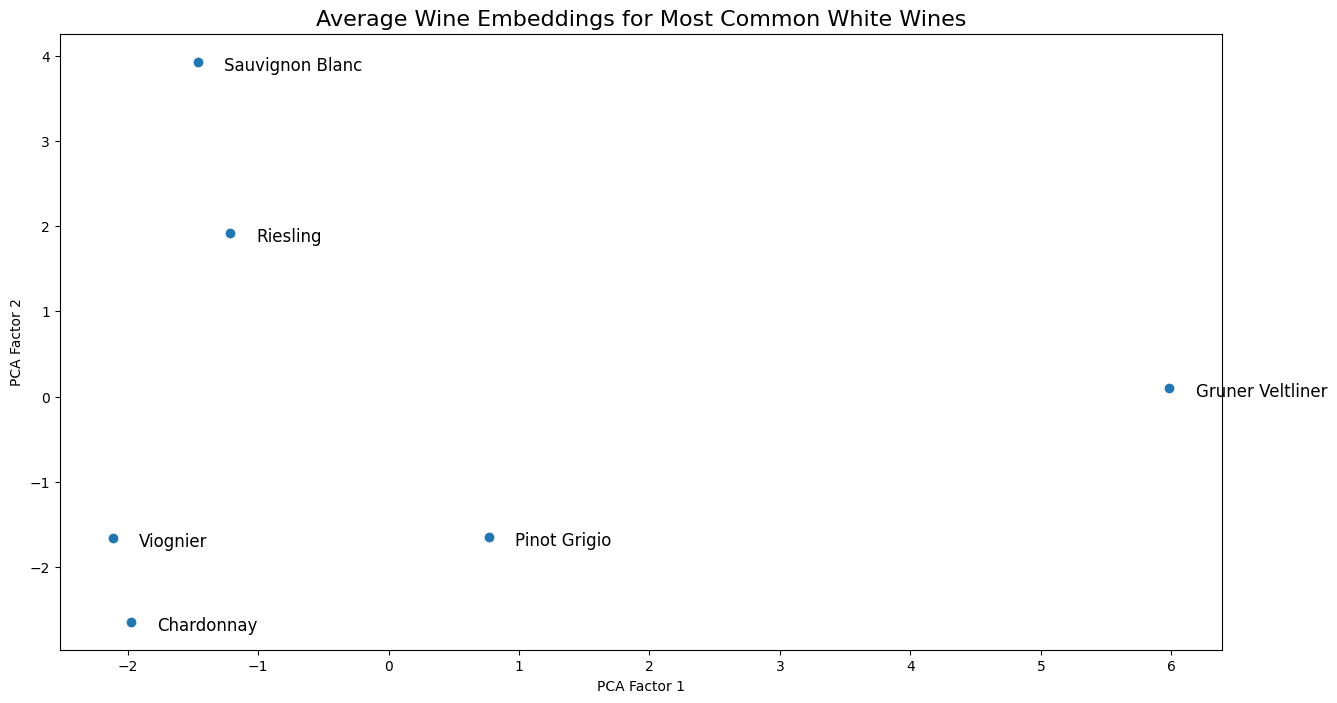

In [25]:
# most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
#                         'Gruner Veltliner', 'Viognier', 'Chenin Blanc', 'Albarino', 'Pinot Blanc', 'Verdejo',
#                         'Torrontes', 'Vermentino', 'Melon', 'Gewurztraminer', 'Rhone-style White Blend']
most_common_whites = ['Chardonnay', 'Sauvignon Blanc', 'Riesling', 'Pinot Grigio', 
                        'Gruner Veltliner', 'Viognier']

pca_w_dataframe = pca_wine_variety(most_common_whites)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_w_dataframe['pca_1'], y=pca_w_dataframe['pca_2'])
for i, txt in enumerate(pca_w_dataframe.index):
    plt.annotate(txt, (list(pca_w_dataframe['pca_1'])[i]+0.2, list(pca_w_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common White Wines', fontsize=16)
plt.show()

At a glance, it appears that the dryer grape varieties (Albarino, Verdejo, Sauvignon Blanc, Melon) are more on the top half of this plot. Slightly sweeter and full-bodied grape varieties such as Chardonnay, Chenin Blanc and Viognier feature on the bottom half of this plot. It is noteworthy how close together Pinot Grigio and Riesling are in the diagram above. It is worth noting that we cannot capture all the variation between these grape varieties in two dimensions, so the above plot is somewhat imperfect. Nevertheless, let's go through the same exercise for the red grape varieties to see what we can learn.

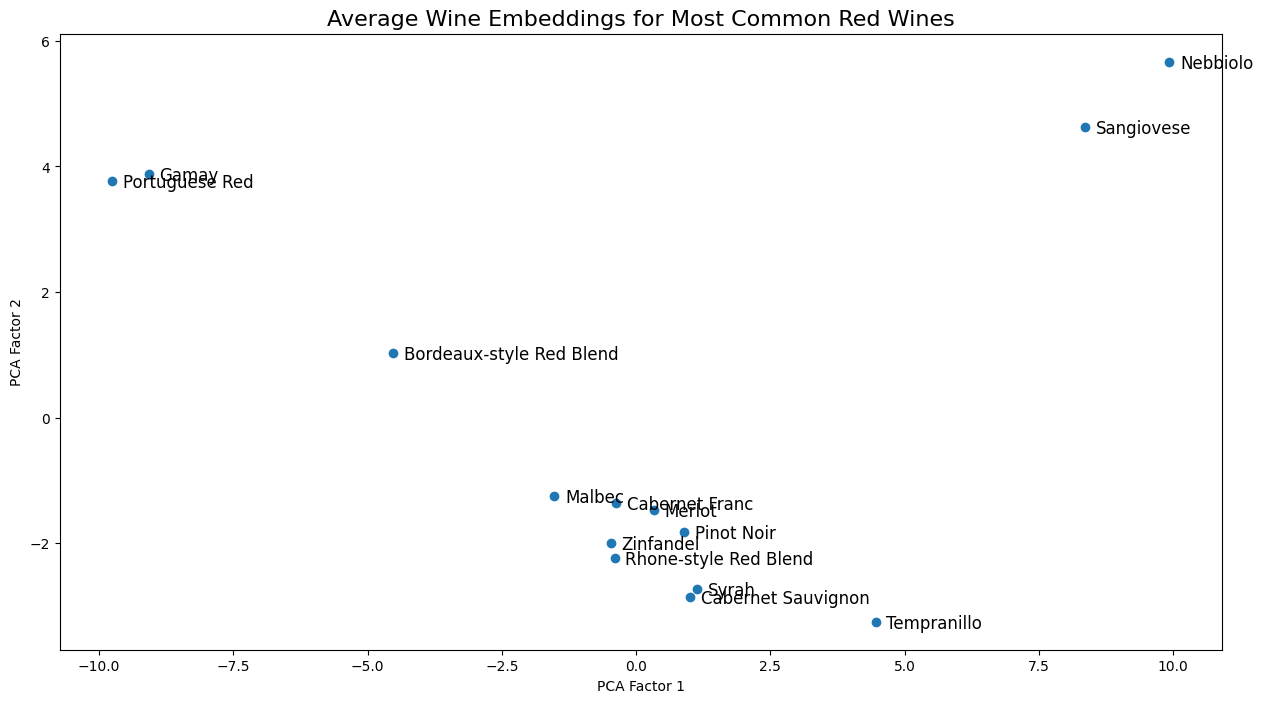

In [26]:
# most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
#                          'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
#                          'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay','Tempranillo Blend, Tempranillo', 'Petite Sirah',
#                         'Barbera', "Nero d'Avola, Italian Red"]
most_common_reds = ['Pinot Noir', 'Cabernet Sauvignon', 'Bordeaux-style Red Blend', 'Syrah', 'Merlot',
                         'Sangiovese', 'Zinfandel', 'Tempranillo', 'Nebbiolo', 'Portuguese Red', 'Malbec',
                         'Rhone-style Red Blend', 'Cabernet Franc', 'Gamay']

pca_r_dataframe = pca_wine_variety(most_common_reds)
plt.figure(figsize=(15, 8))
plt.scatter(x=pca_r_dataframe['pca_1'], y=pca_r_dataframe['pca_2'])
for i, txt in enumerate(pca_r_dataframe.index):
    plt.annotate(txt, (list(pca_r_dataframe['pca_1'])[i]+0.2, list(pca_r_dataframe['pca_2'])[i]-0.1), fontsize=12)

plt.xlabel('PCA Factor 1')
plt.ylabel('PCA Factor 2')
plt.title('Average Wine Embeddings for Most Common Red Wines', fontsize=16)
plt.show()

Plotting the most common red wines, we can see that the Italian grape varieties all sit in the bottom left-hand quadrant of the plot above. It is also noteworthy that Merlot and Cabernet Sauvignon are so close together - this is not surprising, since these two grape varieties are genetically very similar. It is somewhat surprising that Gamay (which produces light-bodied reds that are, in my experience, somewhat similar to Pinot Noir) is way off on the right-hand side of the graph, relatively close to Bordeaux-style Red Blends. 

#### 5.2 Wine Recommender

We can also use our wine review vectors to make wine suggestions. We can do this by using a nearest neighbors model, which calculates the cosine distance between various wine review vectors. The vectorized wine reviews that lie closest to one another are returned as suggestions.

In [27]:
input_vectors = list(wine_reviews_mincount['review_vector'])
input_vectors_listed = [a.tolist() for a in input_vectors]
input_vectors_listed = [a[0] for a in input_vectors_listed]

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric='cosine')
model_knn = knn.fit(input_vectors_listed)

First, let's see what suggestions are returned when we feed this nearest neighbors algorithm a wine we like. To demonstrate this, we have chosen a random wine from our dataset - a Pinot Noir from Santa Barbara, California.

In [28]:
# name_test = "Point & Line 2016 John Sebastiano Vineyard Reserve Pinot Noir (Sta. Rita Hills)"
name_test = "Aspen Peak 2019 Viognier (Grand Valley)"
wine_test_vector = wine_reviews_mincount.loc[wine_reviews_mincount['Name'] == name_test]['review_vector'].tolist()[0]
distance, indice = model_knn.kneighbors(wine_test_vector, n_neighbors=9)
distance_list = distance[0].tolist()[1:]
indice_list = indice[0].tolist()[1:]

main_wine = wine_reviews_mincount.loc[wine_reviews_mincount['Name'] == name_test]

print('Wine to match:', name_test)
print('The original wine has the following descriptors:', list(main_wine['normalized_descriptors'])[0])
print('_________')

n = 1
for d, i in zip(distance_list, indice_list):
    wine_name = wine_reviews_mincount['Name'][i]
    wine_descriptors = wine_reviews_mincount['normalized_descriptors'][i]
    print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
    print('This wine has the following descriptors:', wine_descriptors)
    print('')
    n+=1

Wine to match: Aspen Peak 2019 Viognier (Grand Valley)
The original wine has the following descriptors: ['lemon', 'grass', 'lime_peel', 'juicy', 'juicy', 'vibrant', 'bright', 'ripe', 'apple', 'orange']
_________
Suggestion 1 : Nick Goldschmidt 2021 Forefathers Sauvignon Blanc (Marlborough) with a cosine distance of 0.053
This wine has the following descriptors: ['vibrant', 'lemon', 'orange_peel', 'passion_fruit', 'buoyant', 'citrus']

Suggestion 2 : Standing Stone 2020 Timeline Dry Riesling (Seneca Lake) with a cosine distance of 0.055
This wine has the following descriptors: ['fleshy', 'round', 'mandarin', 'lemon', 'apple', 'brisk', 'rocks', 'dry', 'juicy', 'citrus']

Suggestion 3 : Palmento Costanzo 2019 Mofete White (Etna) with a cosine distance of 0.056
This wine has the following descriptors: ['rocks', 'fruit', 'racy', 'crisp', 'ripe', 'pear', 'apple', 'lemon_drop', 'candy', 'brine']

Suggestion 4 : Dr. Konstantin Frank 2020 Eugenia Dry Riesling (Finger Lakes) with a cosine distan

In [29]:
wine_dataframe.loc[wine_dataframe["Name"].isin(["Aspen Peak 2019 Viognier (Grand Valley)",
                                               "Dr. Konstantin Frank 2020 Eugenia Dry Riesling (Finger Lakes)",
                                               "Dona Maria-JÃºlio Bastos 2018 Dona Maria Branco White (Alentejano)",
                                               "Nick Goldschmidt 2021 Forefathers Sauvignon Blanc (Marlborough)",
                                               "Echo Bay 2021 Sauvignon Blanc (Marlborough)",
                                               "Standing Stone 2020 Timeline Dry Riesling (Seneca Lake)",
                                               "FranÃ§ois Martenot 2019 Brut  (CrÃ©mant de Bourgogne)",
                                               "Sarver 2017 Elhanan Vineyard Pinot Gris (Willamette Valley)"])]

,index,Unnamed: 0,Alcohol,Appellation,Bottle Size,Category,Country,Date Published,Description,Designation,...,Reviewer Twitter Handle,Subregion,User Avg Rating,Variety,Vintage,Winery,Unnamed: 0.1,normalized_descriptors,review_vector,descriptor_count
1397,440,440,13.5%,"Marlborough, New Zealand",750 ml,NaN,New Zealand,1970-01-01T00:00:00+00:00,This is a harmonious and vibrant Sauvignon wit...,Forefathers Sauvignon Blanc (Marlborough),...,@WineEnthusiast,NaN,NaN,Sauvignon Blanc,2021.0,Nick Goldschmidt,NaN,"[vibrant, lemon, orange_peel, passion_fruit, b...","[[2.8647902, 1.5302587, -0.033676486, -3.38759...",6
1574,617,617,13%,"Marlborough, New Zealand",750 ml,NaN,New Zealand,1970-01-01T00:00:00+00:00,"Boisterous aromas of preserved lemon, passion ...",Sauvignon Blanc (Marlborough),...,@WineEnthusiast,NaN,NaN,Sauvignon Blanc,2021.0,Echo Bay,NaN,"[lemon, passion_fruit, grapefruit, grass, pepp...","[[1.965547, 0.53860503, 0.40735847, -2.9352913...",10
2200,296,296,13.5%,"Grand Valley, Colorado, US",750 ml,NaN,US,1970-01-01T00:00:00+00:00,"On the nose, aromas of lemons, grass clippings...",NaN,...,@WineEnthusiast,NaN,NaN,Viognier,2019.0,Aspen Peak,NaN,"[lemon, grass, lime_peel, juicy, juicy, vibran...","[[1.6087463, 1.0612218, -0.40932602, -2.769603...",10
5235,702,702,12%,"CrÃ©mant de Bourgogne, Burgundy, France",750 ml,NaN,France,1970-01-01T00:00:00+00:00,Bristling streaks of grapefruit zest accent ri...,Brut (CrÃ©mant de Bourgogne),...,@WineEnthusiast,NaN,NaN,Sparkling,2019.0,FranÃ§ois Martenot,NaN,"[grapefruit_peel, ripe, apple, juicy, ripe, fr...","[[1.4240388, 1.1182172, -0.78077286, -1.444150...",7
14569,853,853,12.8%,"Willamette Valley, Willamette Valley, Oregon, US",750 ml,NaN,US,1970-01-01T00:00:00+00:00,"Clean, crisp and fresh, this lightly ripened y...",Elhanan Vineyard Pinot Gris (Willamette Valley),...,@WineEnthusiast,Willamette Valley,NaN,Pinot Gris,2017.0,Sarver,853.0,"[clean, crisp, fresh, light_bodied, ripe, appl...","[[1.4699517, 0.7607697, -0.61051136, -2.670410...",9
17296,1762,1762,13%,"Alentejano, Portugal",750 ml,NaN,Portugal,1970-01-01T00:00:00+00:00,"This blend of Arinto, AntÃ£o Vaz and Viosinho ...",Dona Maria Branco White (Alentejano),...,@WineEnthusiast,NaN,NaN,Portuguese White,2018.0,Dona Maria-JÃºlio Bastos,NaN,"[bright, crisp, fresh, lemon, ripe, apple, zes...","[[1.1451691, 1.3819834, -0.31091353, -3.454142...",8
20741,515,515,12%,"Seneca Lake, Finger Lakes, New York, US",750 ml,NaN,US,1970-01-01T00:00:00+00:00,"Fleshy, rounded aromas of Mandarin, lemon oil ...",Timeline Dry,...,@WineEnthusiast,Seneca Lake,NaN,Riesling,2020.0,Standing Stone,NaN,"[fleshy, round, mandarin, lemon, apple, brisk,...","[[1.3178556, 1.0390282, -0.016134715, -2.17206...",10
20759,533,533,12%,"Finger Lakes, Finger Lakes, New York, US",750 ml,NaN,US,1970-01-01T00:00:00+00:00,This Keuka Lake-sourced wine delivers intense ...,Eugenia Dry,...,@WineEnthusiast,Finger Lakes,NaN,Riesling,2020.0,Dr. Konstantin Frank,NaN,"[rocks, candy, lime_peel, juicy, apple, brisk,...","[[1.7350582, 0.6218662, 0.39827752, -2.4885185...",10


In [30]:
wine_reviews_mincount.Name[1090]

'Aspen Peak 2019 Viognier (Grand Valley)'

Great! It appears that the wines being returned as suggestions are also California Pinot Noir wines. Interestingly, many of these wines are even from the Santa Barbara area. The distinctive profile of these wines appears to be captured well by our wine recommender model. The most surprising suggestion returned by our model is a Washington State Cabernet Sauvignon. This cold-climate Cabernet appears have many of the same descriptors (herbs, flower, cherry) as our original (warm-climate) Pinot Noir wine.

Finally, we can also use our wine recommender model to return a suggestion for a wine based on a list of input descriptors. This could be helpful when looking for similarities between wines, or when searching for a particular flavor profile. 

In [31]:
def descriptors_to_best_match_wines(list_of_descriptors, number_of_suggestions=10):
    weighted_review_terms = []
    for term in list_of_descriptors:
        if term not in dict_of_tfidf_weightings:
            if term not in descriptor_mapping.index:
                print('choose a different descriptor from', term)
                continue
            else:
                term = descriptor_mapping['normalized'][term]
        tfidf_weighting = dict_of_tfidf_weightings[term]
        word_vector = wine_word2vec_model.wv.get_vector(term).reshape(1, 300)
        weighted_word_vector = tfidf_weighting * word_vector
        weighted_review_terms.append(weighted_word_vector)
    review_vector = sum(weighted_review_terms)
    
    distance, indice = model_knn.kneighbors(review_vector, n_neighbors=number_of_suggestions+1)
    distance_list = distance[0].tolist()[1:]
    indice_list = indice[0].tolist()[1:]

    n = 1
    for d, i in zip(distance_list, indice_list):
        wine_name = wine_reviews_mincount['Name'][i]
        wine_descriptors = wine_reviews_mincount['normalized_descriptors'][i]
        print('Suggestion', str(n), ':', wine_name, 'with a cosine distance of', "{:.3f}".format(d))
        print('This wine has the following descriptors:', wine_descriptors)
        print('')
        n+=1
    
descriptors = ['complex', 'high_acid', 'fresh', 'grass', 'lime']
descriptors_to_best_match_wines(list_of_descriptors=descriptors, number_of_suggestions=5)

Suggestion 1 : Casas del Bosque 2020 La Cantera Botanic Series Sauvignon Blanc (Casablanca Valley) with a cosine distance of 0.085
This wine has the following descriptors: ['complex', 'wet_rocks', 'lime', 'grass', 'light_bodied', 'peach', 'refreshing', 'white', 'citrus', 'herbacious', 'vibrant', 'minerality']

Suggestion 2 : Cono Sur 2021 Bicicleta Reserva Sauvignon Blanc (Central Valley) with a cosine distance of 0.089
This wine has the following descriptors: ['lime', 'grass', 'herbacious', 'citrus', 'fruit', 'light_bodied']

Suggestion 3 : Stewart 2021 Sauvignon Blanc (Napa Valley) with a cosine distance of 0.101
This wine has the following descriptors: ['steel', 'fruit', 'fresh', 'citrus', 'wet_rocks', 'melon', 'grass']

Suggestion 4 : Tatomer 2019 Oliver's Riesling (Edna Valley) with a cosine distance of 0.102
This wine has the following descriptors: ['grass', 'herb', 'citrus', 'light_bodied', 'complex', 'sizzling']

Suggestion 5 : J. Lohr 2021 Flume Crossing Sauvignon Blanc (Arroy

In [32]:
# Words that non-experts (aka normies) would use
descriptors_trial = ['watery', 'acidic', 'lively', 'tasty', 'champagne']
descriptors_to_best_match_wines(list_of_descriptors=descriptors_trial, number_of_suggestions=5)

choose a different descriptor from acidic
choose a different descriptor from lively
choose a different descriptor from tasty
choose a different descriptor from champagne
Suggestion 1 : Sofia NV Sofia Blanc de Blancs Sparkling (Monterey County) with a cosine distance of 0.238
This wine has the following descriptors: ['sparkling', 'melon_rind', 'lime_peel', 'chalk', 'pillowy', 'mousse']

Suggestion 2 : Faire la FÃªte NV Brut Sparkling (CrÃ©mant de Limoux) with a cosine distance of 0.264
This wine has the following descriptors: ['wet_rocks', 'tart', 'sparkling', 'chalk', 'tart', 'apple', 'wildflower', 'lemon_pith']

Suggestion 3 : Trullo 2020 Riesling (Rheinhessen) with a cosine distance of 0.264
This wine has the following descriptors: ['white_blossom', 'lime_peel', 'zippy', 'dry', 'steel', 'refreshing', 'white', 'cheese']

Suggestion 4 : Five Fourteen Vineyards 2021 Estate Pinot Noir RosÃ© (Willamette Valley) with a cosine distance of 0.264
This wine has the following descriptors: ['pal

When in the mood for a wine that is complex, acidic, fresh, grassy and limey, it appears that we should try a Chilean Sauvignon Blanc - 4 out of the 5 wines returned as suggestions fall in this category. Alternatively, a glass of Cava from Spain might hit the spot too.

#### 6. Conclusion

This notebook is an exercise in two parts. In the first part, we develop a robust method to generate a 'wine embedding' that captures all relevant information from a wine review, maps it onto a set of curated and standardized descriptors, assigns an embedding to each of these descriptors, weights each descriptor using a TF-IDF score and then aggregates the various descriptor vectors to produce a single 'wine embedding' for the full wine review. In the second part of this notebook, we start to explore ways in which we might use these newly created wine embeddings. One way to do this is through a wine recommender model, which measures the cosine distance between wine embeddings to make suggestions. Based on a few examples, we can see that the suggestions that are returned are remarkably consistent. This is a promising result that suggests there is much potential for wine embeddings to be used for future iterations of this work.

# Saruul's trial space

In [33]:
level_3_words = list(descriptor_mapping.level_3.unique())

In [34]:
len(level_3_words)

653

In [35]:
# Words Saruul really wanted to use
descriptors_trial = ['aesthetic', 'acidic', 'lively', 'tasty', 'champagne', 'victorian']

In [36]:
from gensim.models import KeyedVectors
import re

# Load the pre-trained word embeddings model
model = KeyedVectors.load_word2vec_format('../data/misc/glove_6B_50d.txt', binary=False, no_header=True)
available_words = model.key_to_index

In [37]:
def find_closest_word(word, word_list):
    # Check if the word exists in the model's vocabulary
    if word not in model.key_to_index:
        return "Word not found in the vocabulary."

    # Calculate the similarity scores between the given word and the words in the list
    similarity_scores = {w: model.similarity(word, w) for w in word_list if w in available_words}
    # Find the word with the highest similarity score
    closest_word = max(similarity_scores, key=similarity_scores.get)

    return closest_word

def find_closest_wine_descriptors(word_list, wine_descriptor_list = level_3_words):
    return [find_closest_word(word, wine_descriptor_list) for word in word_list]

In [38]:
wine_descriptors = find_closest_wine_descriptors(descriptors_trial)

In [39]:
descriptors_to_best_match_wines(list_of_descriptors=wine_descriptors, number_of_suggestions=5)

Suggestion 1 : Ca' del Bosco NV CuvÃ©e Prestige Extra Brut RosÃ© 43a Edizione Sparkling (Franciacorta) with a cosine distance of 0.231
This wine has the following descriptors: ['violet', 'sparkling', 'vibrant', 'savory', 'dry', 'pomegranate']

Suggestion 2 : SeaGlass 2021 RosÃ© (Monterey County) with a cosine distance of 0.244
This wine has the following descriptors: ['pale', 'brisk', 'watermelon', 'chalk', 'orange', 'rose', 'round', 'watermelon']

Suggestion 3 : Alta Alella 2016 Mirgin Exeo Paratge Qualificat Vallcirera Brut Nature Sparkling (Cava) with a cosine distance of 0.245
This wine has the following descriptors: ['sparkling', 'yellow', 'flower', 'lemon', 'cake', 'rosewater', 'savory']

Suggestion 4 : Ferrari 2016 PerlÃ© RosÃ© Riserva Sparkling (Trento) with a cosine distance of 0.257
This wine has the following descriptors: ['tangy', 'brioche', 'alpine_herbs', 'elegant', 'sparkling', 'savory', 'pomegranate', 'cream', 'peach', 'bread_crust']

Suggestion 5 : Bestheim NV Brut Pre

In [41]:
"".join(["yes", "hello"])

'yeshello'